This notebook quickly generates the plots for our current paper. 

# Setup

## Imports 

In [1]:
# Standard
import sys
# Third party
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import proplot as plot
# Local                                                                        
sys.path.append('/Users/46h/Research/code/accphys') 
from tools import (
    envelope_analysis as ea,
    plotting as myplt,
    animation as myanim,
    utils)
from tools.plotting import set_labels

## Settings

In [2]:
plt_kws = dict(legend=False, xlabel='s / L')
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None # `None` for default proplot style

cmap = plot.Colormap('fire_r')
cmap_range = (0, 0.9)
dpi = 500

## Read Data

In [3]:
latnames = [f.rstrip() for f in open('_output/data/latnames.txt', 'r')]
perveances = np.load('_output/data/perveances.npy')

tracked_env_params_dict = {} 
transfer_mats_dict = {}
stats_dict = {}
positions_dict = {}

for latname in latnames:
    for mode in (1, 2):
        key = latname + '_mode{}'.format(mode)
        print('Loading', key, '...')

        # Load the list of tracked envelope parameters and transfer matrices        
        tracked_env_params_list = np.load('_output/data/tracked_env_params_list_{}_{}.npy'.format(latname, mode))
        tranfer_mat_list = np.load('_output/data/transfer_mats_{}_{}.npy'.format(latname, mode))
        positions = np.load('_output/data/positions_{}.npy'.format(latname))
        
        # Compute the beam statistics for each set of envelope parameters in the list
        stats_list = []
        for i, tracked_env_params in enumerate(tracked_env_params_list):
            stats = ea.Stats(mode)
            stats.read_env(tracked_env_params)
            beta_x = stats.twiss2D.loc[:, 'bx'].values
            beta_y = stats.twiss2D.loc[:, 'by'].values
            stats.twiss2D['mux'] = utils.get_phase_adv(beta_x, positions, units='deg')
            stats.twiss2D['muy'] = utils.get_phase_adv(beta_y, positions, units='deg')
            
            if latname.startswith('fodo_split') and perveances[i] == 0:
                stats.twiss4D['nu'] = 90.0
                
            for df in stats.dfs():
                df['s'] = positions
                df['s/L'] = positions / positions[-1]
            stats_list.append(stats)
            
        stats_dict[key] = stats_list
        tracked_env_params_dict[key] = tracked_env_params_list
        transfer_mats_dict[key] = tranfer_mat_list
        positions_dict[key] = positions
        
print('Done.')

Loading fodo_mode1 ...
Loading fodo_mode2 ...
Loading fodo_split_mode1 ...
Loading fodo_split_mode2 ...
Loading fodo_skew_mode1 ...
Loading fodo_skew_mode2 ...


/Users/46h/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Loading fodo_sol_mode1 ...
Loading fodo_sol_mode2 ...
Done.


In [4]:
_cycler = myplt.colorcycle(cmap, len(perveances), cmap_range)

# Plot

## Phase space projections at lattice entrance

In [5]:
# for key, tracked_env_params_list in tracked_env_params_dict.items():
#     print('Plotting', key, '...')
#     axes = myplt.corner_env(tracked_env_params_list[:, 0, :], figsize=5, pad=0.25, lw=1, 
#                             cmap=cmap, cmap_range=cmap_range)
#     plt.savefig('_output/figures/corner_vs_sc_{}.png'.format(key), dpi=500, facecolor='white')
#     plt.close()
# # print('Done.')

## Twiss parameters within lattice

In [6]:
grouped_keys = [('fodo_mode1', 'fodo_mode2'), 
                ('fodo_split_mode1', 'fodo_split_mode2'), 
                ('fodo_skew_mode1', 'fodo_skew_mode2'), 
                ('fodo_sol_mode1', 'fodo_sol_mode2')]

In [7]:
for keys in grouped_keys:
    fig, axes = plot.subplots(nrows=3, ncols=2, figsize=(6.5, 6), spany=False, aligny=True)
    axes.set_prop_cycle(_cycler)
    for j, key in enumerate(keys):
        print('Plotting', key, '...')
        stats_list = stats_dict[key]
        for stats in stats_list:
            lw = 1.1
            stats.moments[['s/L','x_rms']].plot('s/L', ax=axes[0, j], lw=lw, **plt_kws)
            stats.twiss2D[['s/L','ex']].plot('s/L', ax=axes[1, j], lw=lw, **plt_kws)
            stats.twiss4D[['s/L','nu']].plot('s/L', ax=axes[2, j], lw=lw, **plt_kws)
        for stats in stats_list:
            stats.moments[['s/L','y_rms']].plot('s/L', ax=axes[0, j], ls='--', zorder=0, legend=False, lw=1.1)
            stats.twiss2D[['s/L','ey']].plot('s/L', ax=axes[1, j], ls='--', zorder=0, legend=False, lw=1.1)
    axes[2, 0].format(yformatter='deg')
    axes.format(grid=False, toplabels=['Solution 1', 'Solution 2'])
    set_labels(axes[:, 0], ['Beam size [mm]', r'Emittance [$mm \cdot mrad$]', r'$\nu$'], 'ylabel')
    cbar = fig.colorbar(cmap, width=0.075, ticks=[0], label='Perveance', pad=3)
    cbar.set_label('Perveance', labelpad=-5)
    # Save
    tag = key[:-5]
    plt.savefig('_output/figures/param_vs_sc_{}.png'.format(tag), dpi=dpi, facecolor='w')
    plt.close()
print('Done.')

Plotting fodo_mode1 ...
Plotting fodo_mode2 ...
Plotting fodo_split_mode1 ...
Plotting fodo_split_mode2 ...
Plotting fodo_skew_mode1 ...
Plotting fodo_skew_mode2 ...
Plotting fodo_sol_mode1 ...
Plotting fodo_sol_mode2 ...
Done.


## Combined plot 

Build specialized plot for the paper.

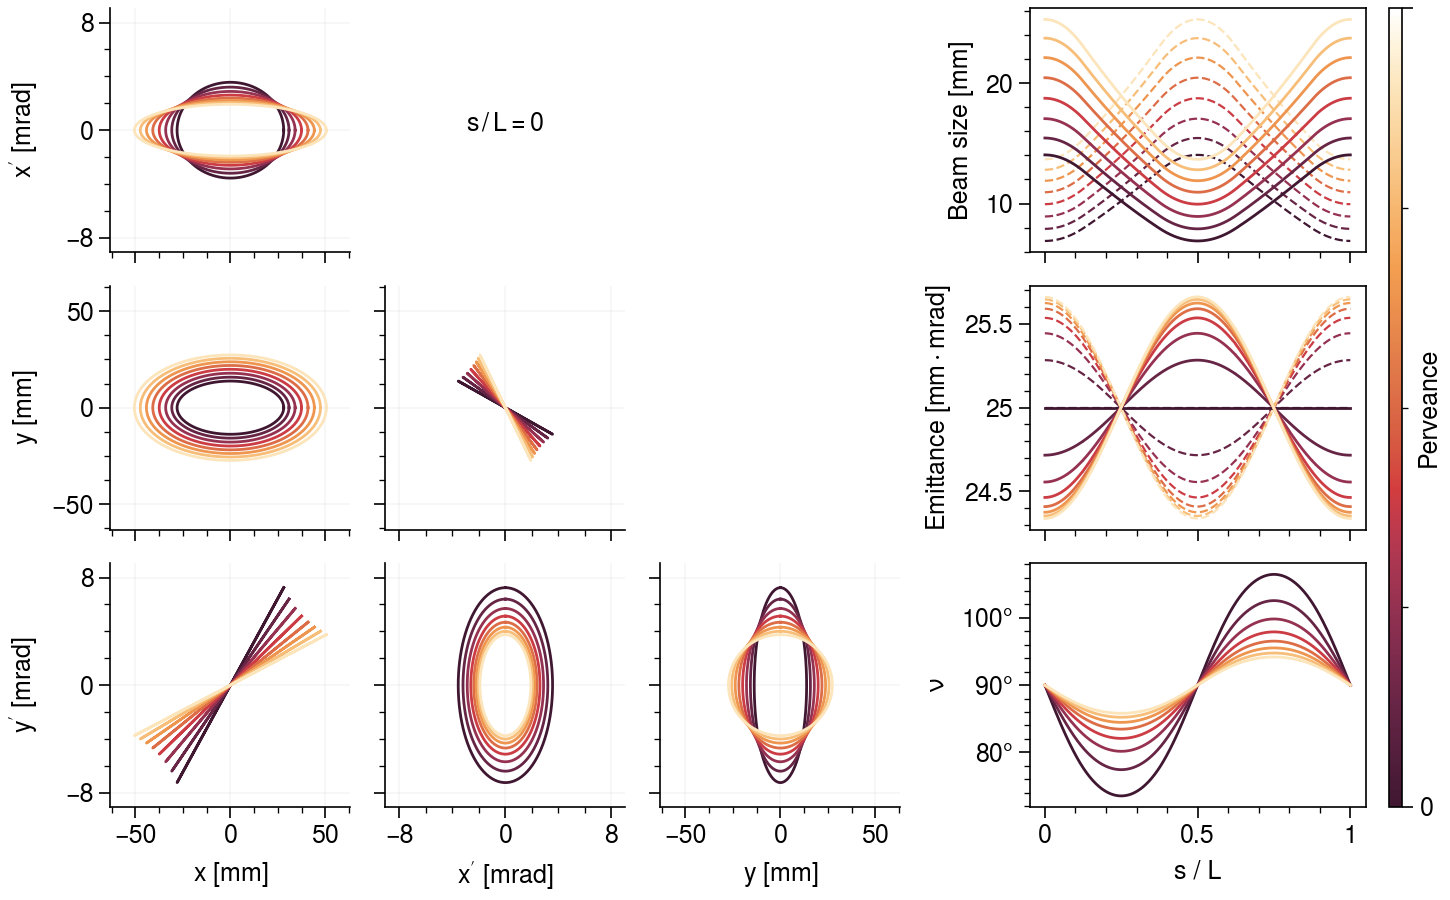

In [8]:
def plot_combined(key, text=r'$s \,/\, L = 0$', colorbar=True):
    """Plot 3 beam parameters as a function of s next to the transverse phase
    space projections."""

    # Create figure (constrained_layout > tight_layout)
    fig, axes = plt.subplots(3, 4, figsize=(7.25, 4.5), constrained_layout=True,
                             gridspec_kw=dict(width_ratios=[1, 1, 1, 1.4]))
    left, right = axes[:, :-1], axes[:, -1] 
    myplt.despine(left.flat)
    myplt.make_lower_triangular(left)

    # Share axes
    for col in axes.T:
        myplt.set_share_axes(col, sharex=True)
    for row in left:
        myplt.set_share_axes(row, sharey=True)

    # Set color cycle
    for ax in left.flat:
        ax.set_prop_cycle(_cycler)

    # Get ellipse boundary data
    params = tracked_env_params_dict[key][:, 0, :]
    if type(params) is not np.ndarray:
        params = np.array(params)
    if params.ndim == 1:
        params = params[np.newaxis, :]
    coords = ea.get_ellipse_coords(params)

    # Set up figure
    umax, upmax = 1.25 * myplt.get_u_up_max_global(coords)
    limits = 2 * [(-umax, umax), (-upmax, upmax)]
    labels = myplt.get_labels(units='mm-mrad')
    loc_u, loc_up = matplotlib.ticker.MaxNLocator(3), matplotlib.ticker.MaxNLocator(3)
    mloc_u, mloc_up = matplotlib.ticker.AutoMinorLocator(4), matplotlib.ticker.AutoMinorLocator(4)
    locators = 2 * [loc_u, loc_up]
    mlocators = 2 * [mloc_u, mloc_up]
    myplt.set_labels(left[-1, :], labels[:-1], 'xlabel')
    myplt.set_labels(left[:, 0], labels[1:], 'ylabel')
    myplt.set_labels(right, ['Beam size [mm]', r'Emittance [$mm \cdot mrad$]', r'$\nu$'], 'ylabel')
    fig.align_labels(left)
#     fig.align_ylabels(right)
    myplt.set_limits(left[:, 0], limits[1:], 'y')
    myplt.set_limits(left[-1, :], limits[:-1], 'x')
    for row, loc, mloc in zip(left, locators[1:], mlocators[1:]):
        for ax in row:
            ax.yaxis.set_major_locator(loc)
            ax.yaxis.set_minor_locator(mloc)
    for col, loc, mloc in zip(left.T, locators, mlocators):
        for ax in col:
            ax.xaxis.set_major_locator(loc)
            ax.xaxis.set_minor_locator(mloc)
    right[-1].yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter(u'{x:.0f}°'))

    # Plot envelope data
    for X in coords:
        X_horiz, X_vert = X[:, :-1], X[:, 1:]
        for i in range(3):
            for j in range(i + 1):
                left[i, j].plot(X_horiz[:, j], X_vert[:, i], lw=1, zorder=10)

    # Plot parameters as a function of s
    plt_kws.setdefault('lw', 1)
    stats_list = stats_dict[key]
    for ax in right:
        ax.set_prop_cycle(_cycler)
    for stats in stats_list:
        stats.moments[['s/L','x_rms']].plot('s/L', ax=right[0], **plt_kws)
        stats.twiss2D[['s/L','ex']].plot('s/L', ax=right[1], **plt_kws)
        stats.twiss4D[['s/L','nu']].plot('s/L', ax=right[2], yunits='degrees', **plt_kws)
    right[0].set_prop_cycle(_cycler)
    for stats in stats_list:
        stats.moments[['s/L','y_rms']].plot('s/L', ax=right[0], ls='--', zorder=0, legend=False, lw=0.8)
        stats.twiss2D[['s/L','ey']].plot('s/L', ax=right[1], ls='--', zorder=0, legend=False, lw=0.8)

    # Turn off grid for line plots
    for ax in right:
        ax.grid(False)
        
    axes[0, 1].annotate(text, xy=(0.5, 0.5), xycoords='axes fraction', horizontalalignment='center')
    
    if colorbar:
        norm = matplotlib.colors.Normalize(vmin=cmap_range[0], vmax=cmap_range[1])
        cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), ax=axes[:, -1].ravel().tolist(), 
                            aspect=100, pad=0.005)
        cbar.set_ticks(cmap_range)
        cbar.set_ticklabels([r'$0$', ''])
        cbar.set_label('Perveance', labelpad=-6)
    return axes

plot_combined('fodo_mode1');

In [9]:
for key in stats_dict.keys():
    print('Plotting', key, '...')
    axes = plot_combined(key, colorbar=True)
    plt.savefig('_output/figures/matched_vs_sc_{}.png'.format(key), dpi=500, facecolor='white')
    plt.close()
print('Done.')

Plotting fodo_mode1 ...
Plotting fodo_mode2 ...
Plotting fodo_split_mode1 ...
Plotting fodo_split_mode2 ...
Plotting fodo_skew_mode1 ...
Plotting fodo_skew_mode2 ...
Plotting fodo_sol_mode1 ...
Plotting fodo_sol_mode2 ...
Done.


## Effective transfer matrix 

### Eigenvalues

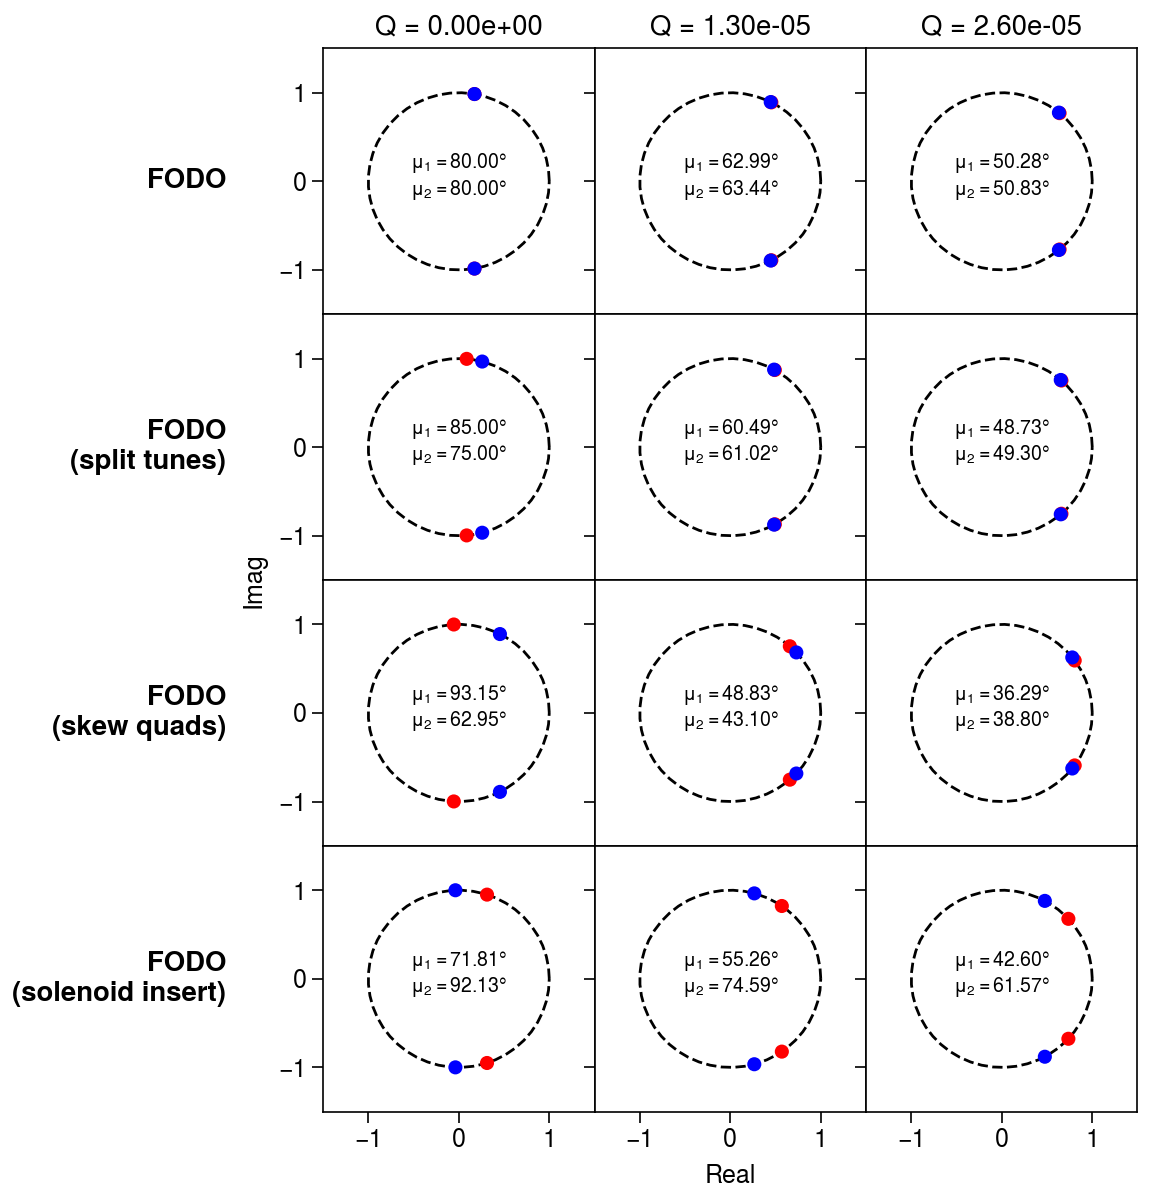

In [10]:
nrows, ncols = 4, 3
s = 20
fontsize = 7

fig, axes = plot.subplots(nrows=4, ncols=3, figsize=(5.75, 6), hspace=0, wspace=0)
myplt.set_labels(axes[0, :], ['Q = {:.2e}'.format(Q) for Q in perveances[:3]], 'title')

# Plot unit circle in background
psi = np.linspace(0, 2*np.pi, 50)
x_circle, y_circle = np.cos(psi), np.sin(psi)
for ax in axes:
    ax.plot(x_circle, y_circle, 'k--', lw=1, zorder=0)
    
# Plot eigenvalues
keys = transfer_mats_dict.keys()
keys_solution1 = [key for key in keys if key.endswith('1')]
keys_solution2 = [key for key in keys if key.endswith('2')]

for i, key in enumerate(keys_solution1):
    transfer_mat_list = transfer_mats_dict[key]
    for ax, M in zip(axes[i, :], transfer_mat_list[:3]):
        eigvals, eigvecs = np.linalg.eig(M)
        ax.scatter(eigvals.real, eigvals.imag,  s=s, c=('r', 'r', 'b', 'b'), zorder=1)
        mu1, _, mu2, _ = np.degrees(np.arccos(eigvals.real))
        split = 0.05
        ax.annotate(r'$\mu_1 = {:.2f}\degree$'.format(mu1), xy=(0.5, 0.5+split), 
                    xycoords='axes fraction', horizontalalignment='center', fontsize=fontsize)
        ax.annotate(r'$\mu_2 = {:.2f}\degree$'.format(mu2), xy=(0.5, 0.5-split), 
                    xycoords='axes fraction', horizontalalignment='center', fontsize=fontsize)
        
# Formatting
scale = 1.5
axes.format(
    grid=False,
    xlim=(-scale, scale), ylim=(-scale, scale), xlabel='Real', ylabel='Imag',
    xticks=[-1, 0, 1], yticks=[-1, 0, 1],
    leftlabels=['FODO', 'FODO\n(split tunes)', 'FODO\n(skew quads)', 'FODO\n(solenoid insert)'], 
    xminorlocator='null', yminorlocator='null'
)
        
plt.savefig('_output/figures/eigvals.png', dpi=dpi, facecolor='w')